# Comparison of different regression methods

In [1]:
%load_ext autoreload
%autoreload 2
from pytree import *
import random
import matplotlib.pyplot as plt
import numpy
import time

print(__version__)
print(__git_version__)

0.0.6
1266b2d2ee8b5c151190f418475fa799ff09b852


In [2]:
import pandas
df = pandas.read_csv('test_data/memcpy.csv')
df = df.groupby('size').mean().reset_index()
df = df.sample(n=min(100, len(df)), random_state=42)  # we take only 100 points to have a shorter duration
df

,size,duration
608,15402181,2.846535e-03
457,545336,2.985634e-05
290,14329,3.530780e-07
558,5629667,5.211696e-04
168,1140,6.329000e-08
...,...,...
412,200333,1.067195e-05
355,51739,2.700214e-06
266,9573,2.010620e-07
527,2711427,2.399503e-04


In [3]:
def do_regressions(df, mode):
    t = time.time()
    reg = compute_regression(df['size'], df['duration'], mode=mode)
    print(f'Top-down   : {time.time()-t:.3f} seconds')
    print(f'Breakpoints: {reg.breakpoints}')
    reg.plot_dataset(log=True)
    t = time.time()
    reg = reg.auto_simplify()
    print(f'Bottom-up  : {time.time()-t:.3f} seconds')
    print(f'Breakpoints: {reg.breakpoints}')
    reg.plot_dataset(log=True)
    return reg

## Original dataset

First, let's try the three different regressions on the original dataset.

### Classical linear regression

Top-down   : 0.036 seconds
Breakpoints: [9573, 14495, 477185, 992466, 5629667]
Bottom-up  : 0.043 seconds
Breakpoints: [5629667]


-inf < x ≤ 5.630e+06
	y ~ 9.037e-11x + -3.647e-06
5.630e+06 < x ≤ inf
	y ~ 1.988e-10x + -3.235e-04

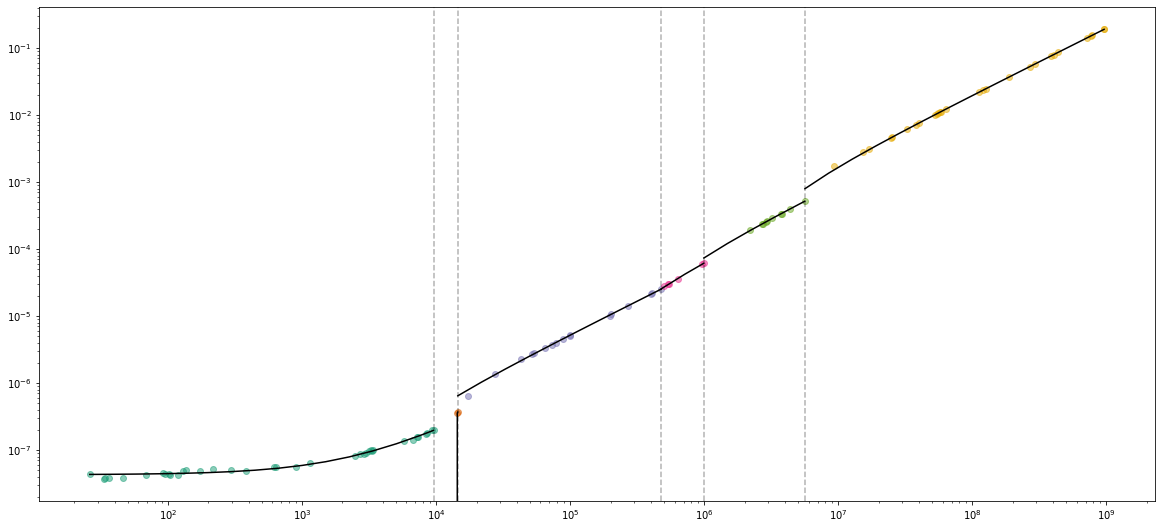

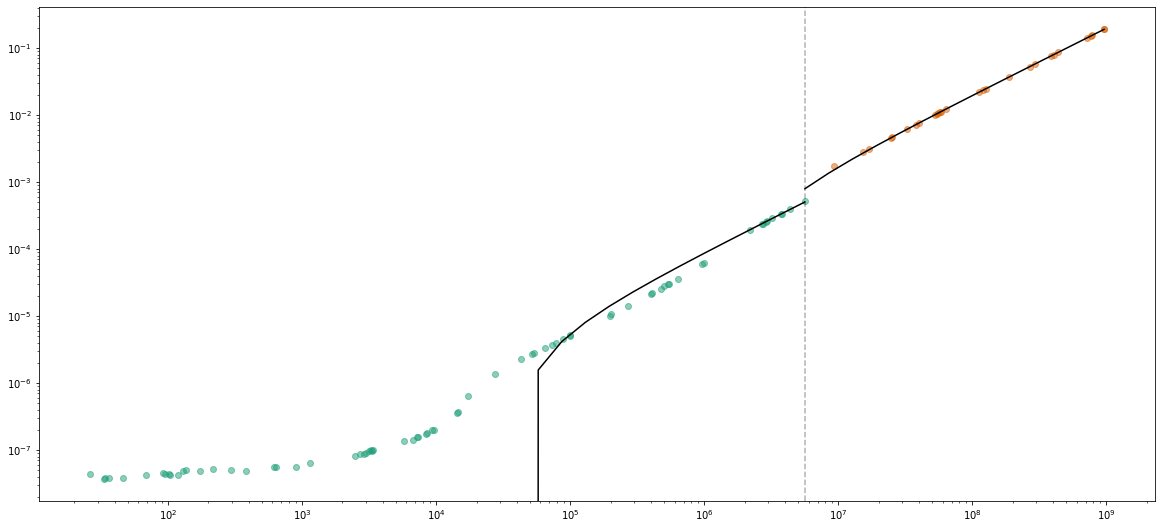

In [4]:
reg = do_regressions(df, 'BIC')
reg

### Weighted linear regression

Top-down   : 0.124 seconds
Breakpoints: [992466, 5629667, 24997847]
Bottom-up  : 0.013 seconds
Breakpoints: [992466]


-inf < x ≤ 9.925e+05
	y ~ 5.548e-11x + 3.462e-08
9.925e+05 < x ≤ inf
	y ~ 1.988e-10x + -3.385e-04

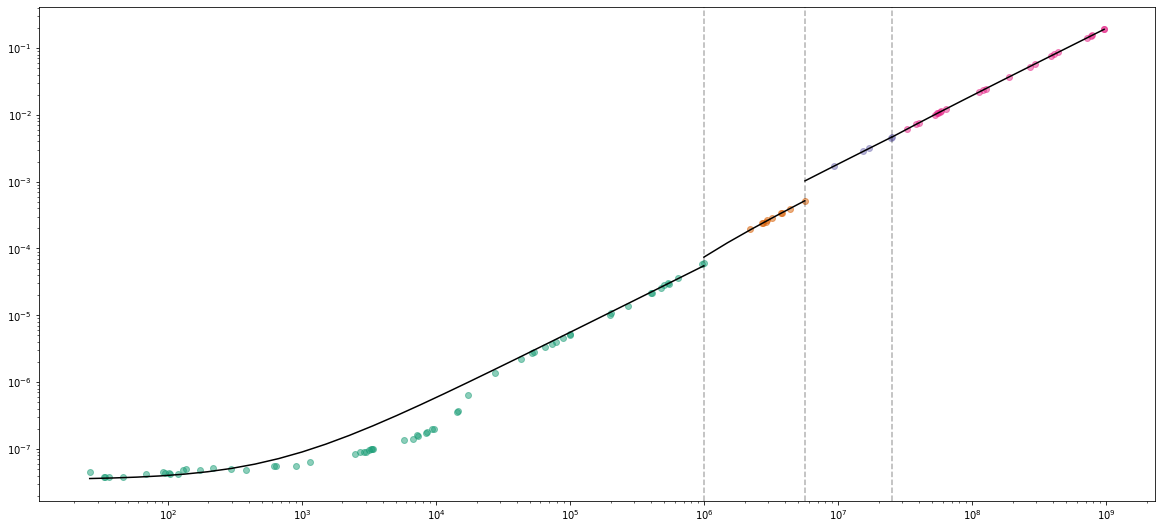

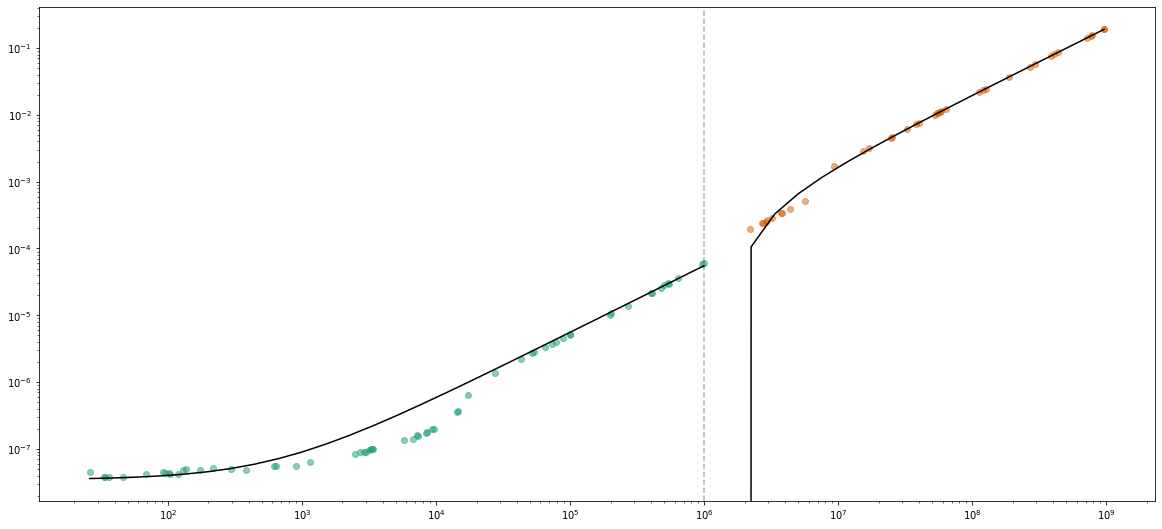

In [5]:
reg = do_regressions(df, 'weighted')
reg

### Log regression

Top-down   : 4.264 seconds
Breakpoints: [14495, 992466, 5629667]
Bottom-up  : 0.217 seconds
Breakpoints: [14495, 992466, 5629667]


-inf < x ≤ 1.450e+04
	y ~ 1.739e-11x + 4.181e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.457e-11x + 2.939e-39
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.929e-11x + 1.030e-20
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

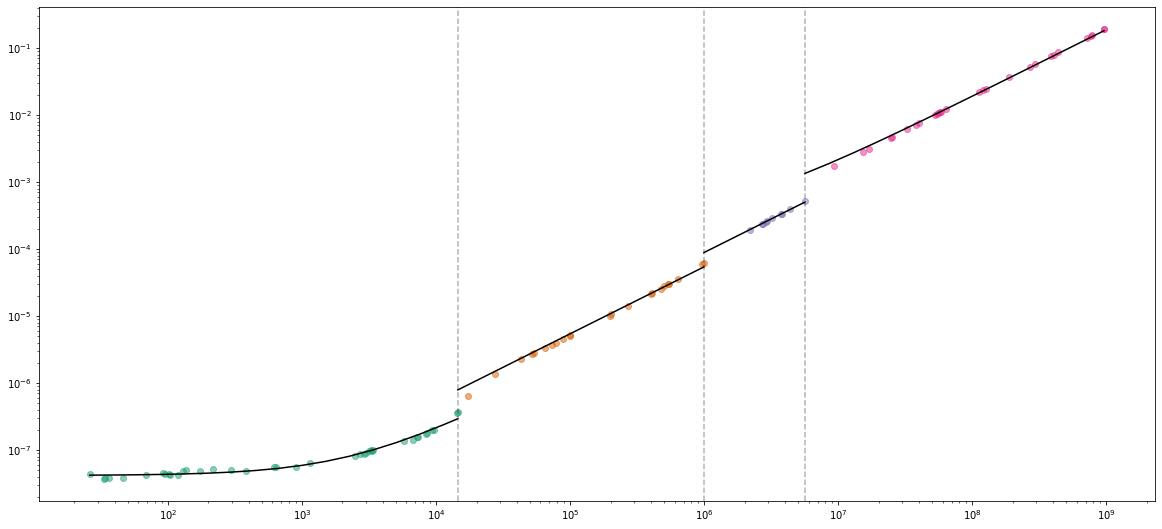

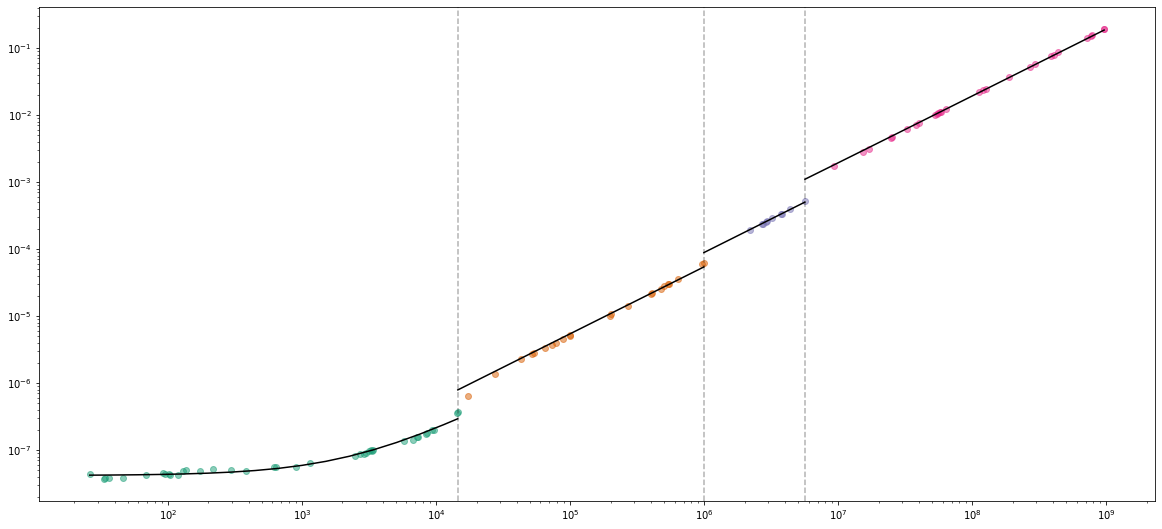

In [6]:
reg = do_regressions(df, 'log')
reg

## Generated data

Now, let's generate a new dataset. We will use **exactly** the same X values of the previous dataset. The Y values will be computed using the last regression we had, without any noise. The goal here is to see if the poor performance of the classical or the weighted regressions can be entirely explained by the heteroscedasticity of the data, or if there is something else.

In [7]:
new_df = df.copy()
new_df['duration'] = new_df.apply(lambda row: reg.predict(row['size']), axis=1)

### Classical linear regression

Top-down   : 0.029 seconds
Breakpoints: [14495, 992466, 5629667]
Bottom-up  : 0.015 seconds
Breakpoints: [14495, 992466, 5629667]


-inf < x ≤ 1.450e+04
	y ~ 1.739e-11x + 4.181e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.457e-11x + 6.776e-21
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.929e-11x + 5.421e-20
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

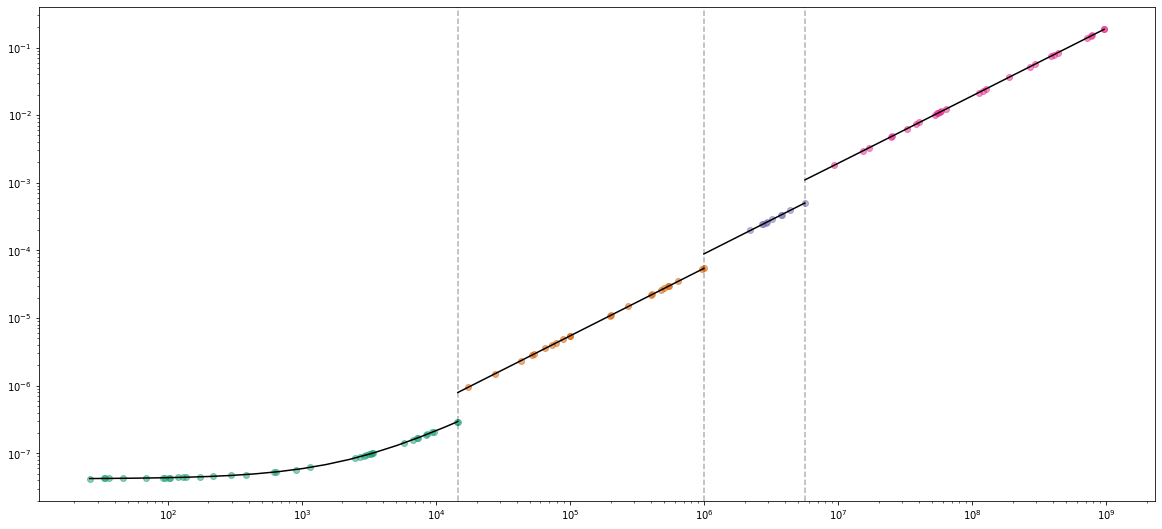

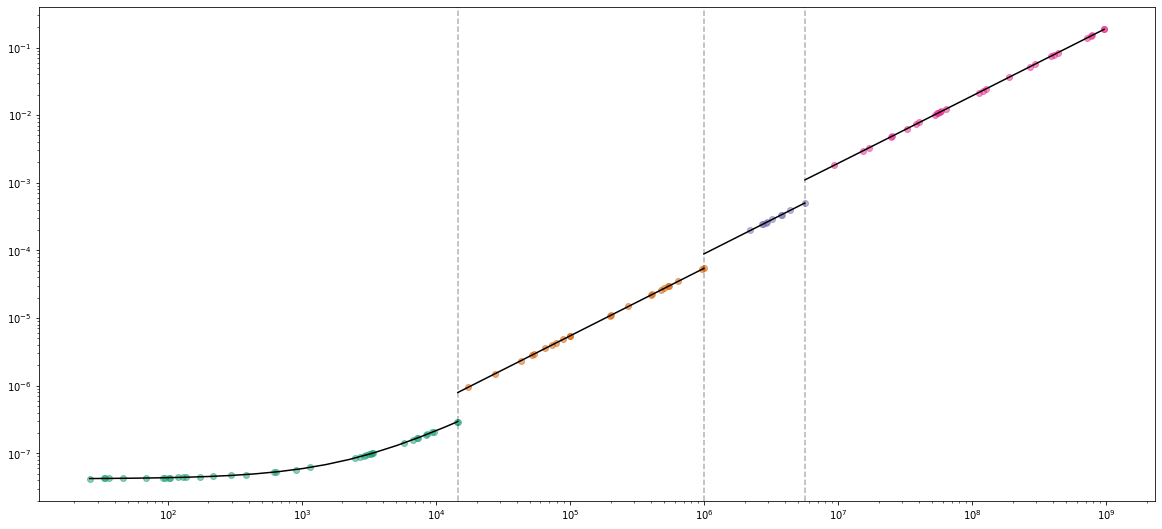

In [8]:
reg = do_regressions(new_df, 'BIC')
reg

### Weighted linear regression

Top-down   : 0.118 seconds
Breakpoints: [2908, 14495, 88146, 992466, 5629667, 15402181]
Bottom-up  : 0.025 seconds
Breakpoints: [2908, 14495, 992466, 5629667]


-inf < x ≤ 2.908e+03
	y ~ 1.739e-11x + 4.181e-08
2.908e+03 < x ≤ 1.450e+04
	y ~ 1.739e-11x + 4.181e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.457e-11x + 1.694e-21
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.929e-11x + 0.000e+00
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

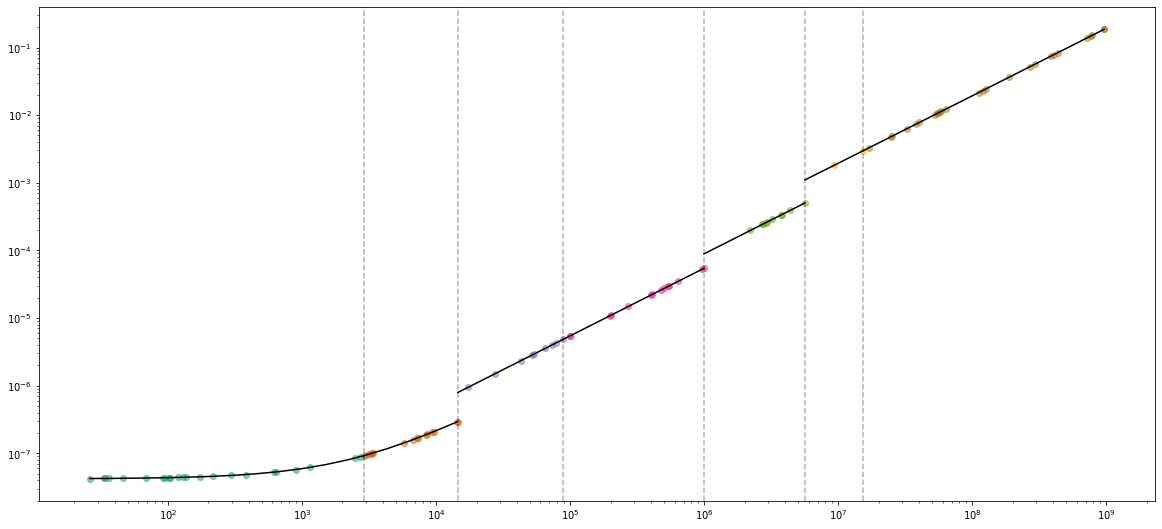

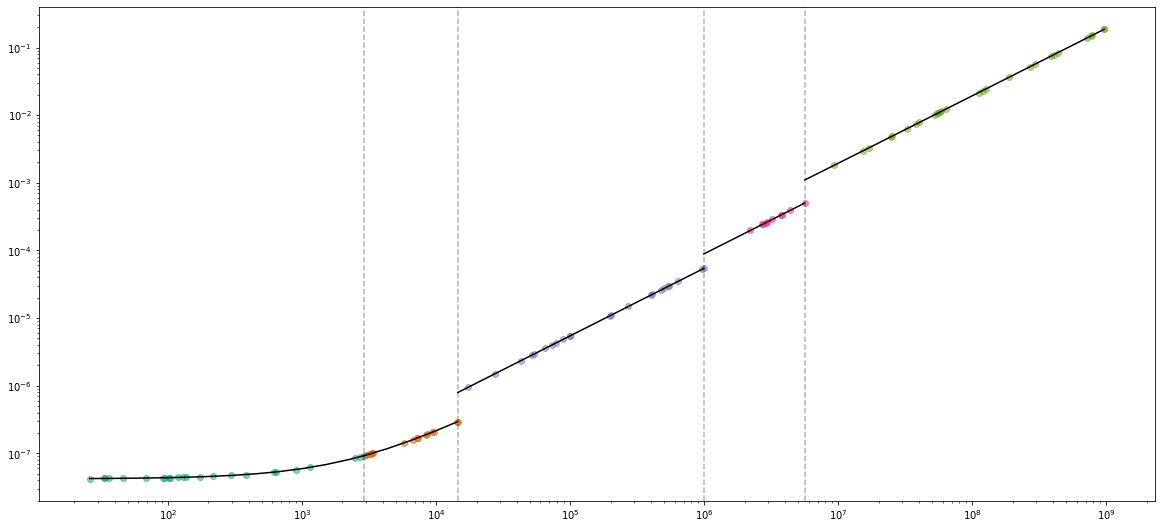

In [9]:
reg = do_regressions(new_df, 'weighted')
reg

### Log regression

Top-down   : 2.459 seconds
Breakpoints: [17257, 992466, 5629667]
Bottom-up  : 0.313 seconds
Breakpoints: [17257, 992466, 5629667]


-inf < x ≤ 1.726e+04
	y ~ 1.922e-11x + 4.091e-08
1.726e+04 < x ≤ 9.925e+05
	y ~ 5.457e-11x + 3.388e-21
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.929e-11x + 5.421e-20
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

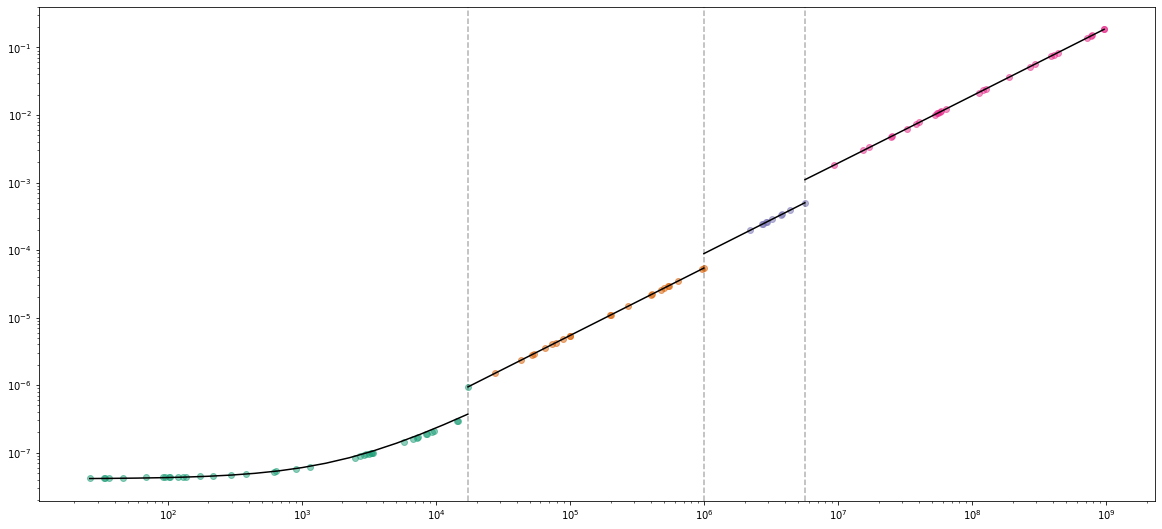

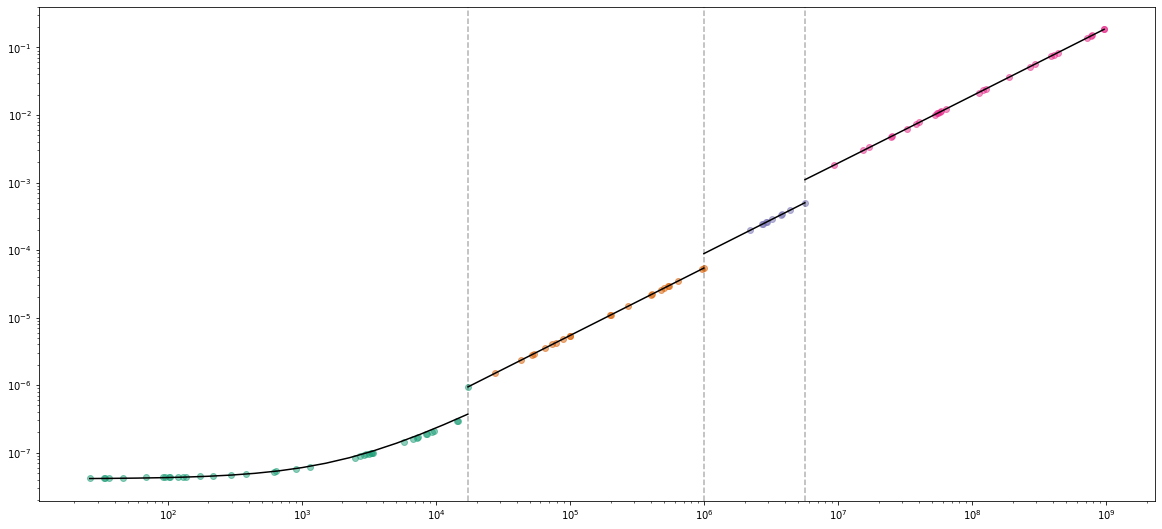

In [10]:
reg = do_regressions(new_df, 'log')
reg

## Generated data, generated homoscedastic noise

Let's try to add some homoscedastic noise.

In [11]:
noisy_df = new_df.copy()
noisy_df['duration'] += numpy.random.normal(size=len(noisy_df), scale=2e-8)

### Classical linear regression

Top-down   : 0.047 seconds
Breakpoints: [14495, 992466, 5629667]
Bottom-up  : 0.017 seconds
Breakpoints: [14495, 992466, 5629667]


-inf < x ≤ 1.450e+04
	y ~ 1.715e-11x + 4.015e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.457e-11x + 8.595e-10
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.929e-11x + -2.103e-08
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

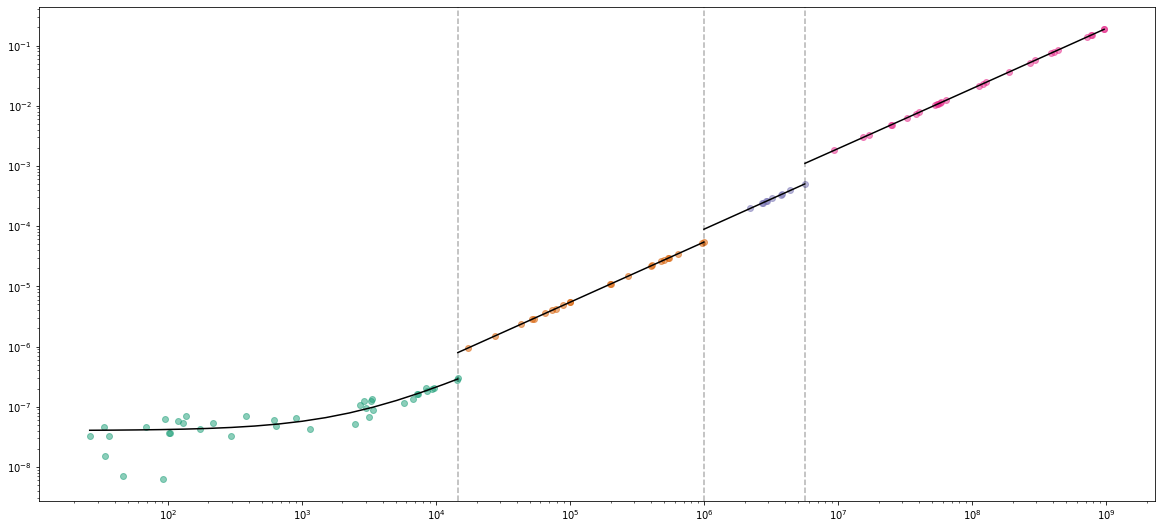

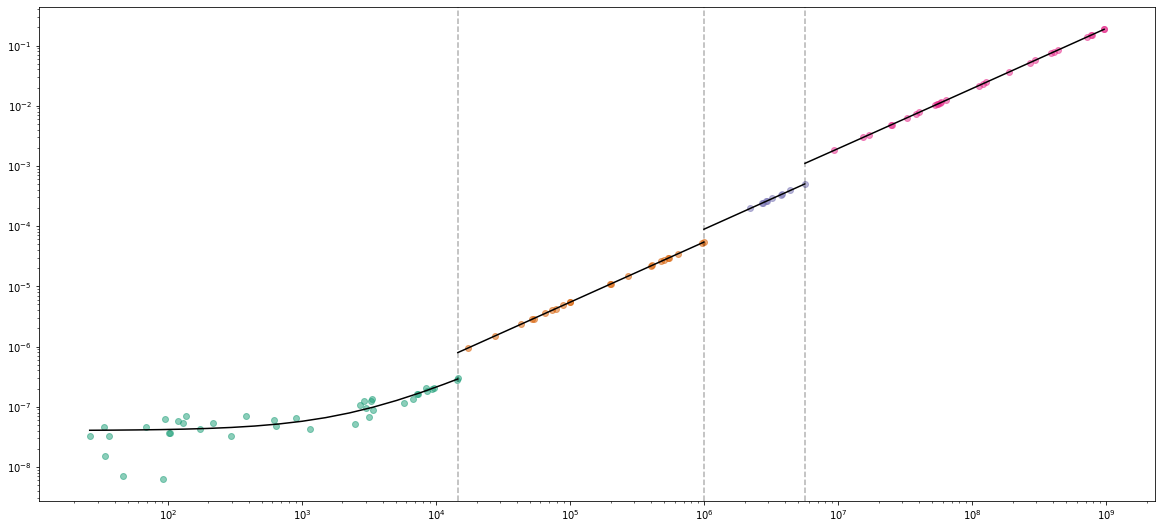

In [12]:
reg = do_regressions(noisy_df, 'BIC')
reg

### Weighted linear regression

Top-down   : 0.123 seconds
Breakpoints: [992466, 5629667]
Bottom-up  : 0.011 seconds
Breakpoints: [992466]


-inf < x ≤ 9.925e+05
	y ~ 5.390e-11x + 2.820e-08
9.925e+05 < x ≤ inf
	y ~ 1.946e-10x + -2.930e-04

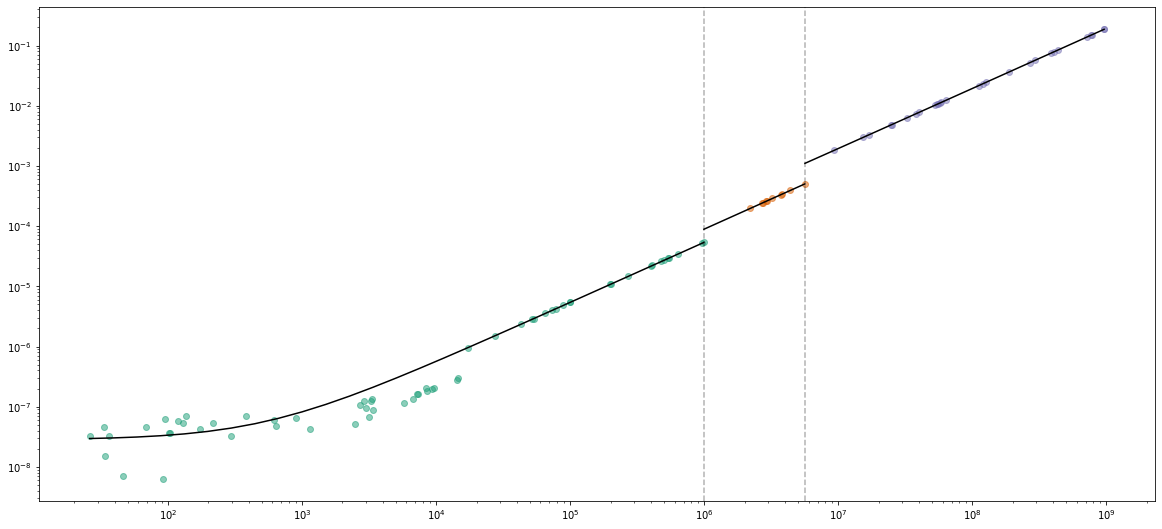

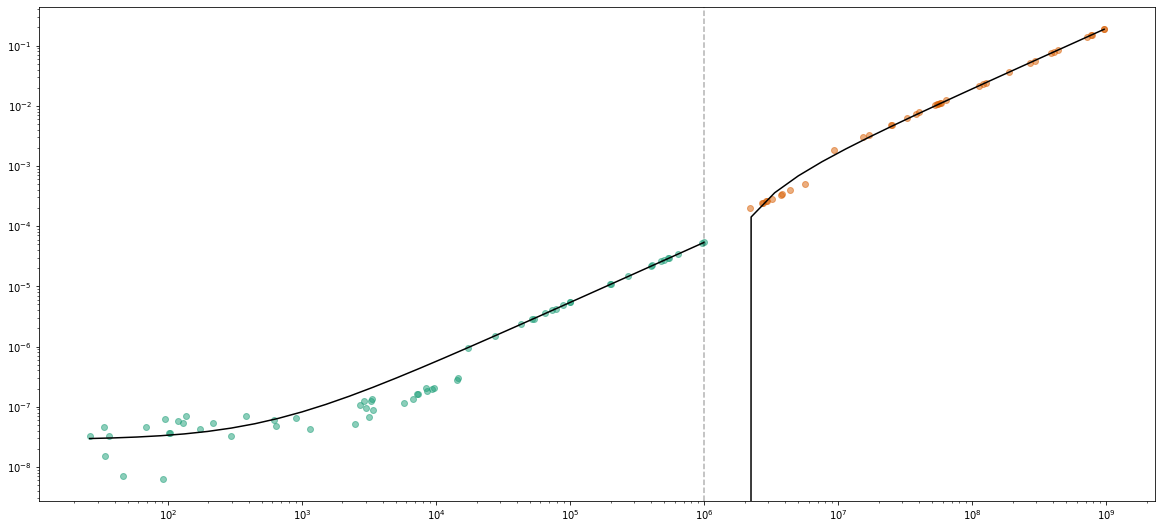

In [13]:
reg = do_regressions(noisy_df, 'weighted')
reg

### Log regression

Top-down   : 5.729 seconds
Breakpoints: [95, 14495, 992466, 5629667]
Bottom-up  : 0.199 seconds
Breakpoints: [95, 14495, 992466, 5629667]


-inf < x ≤ 9.500e+01
	y ~ 2.870e-42x + 2.399e-08
9.500e+01 < x ≤ 1.450e+04
	y ~ 1.614e-11x + 4.441e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.456e-11x + 8.595e-10
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.928e-11x + 2.103e-08
5.630e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05

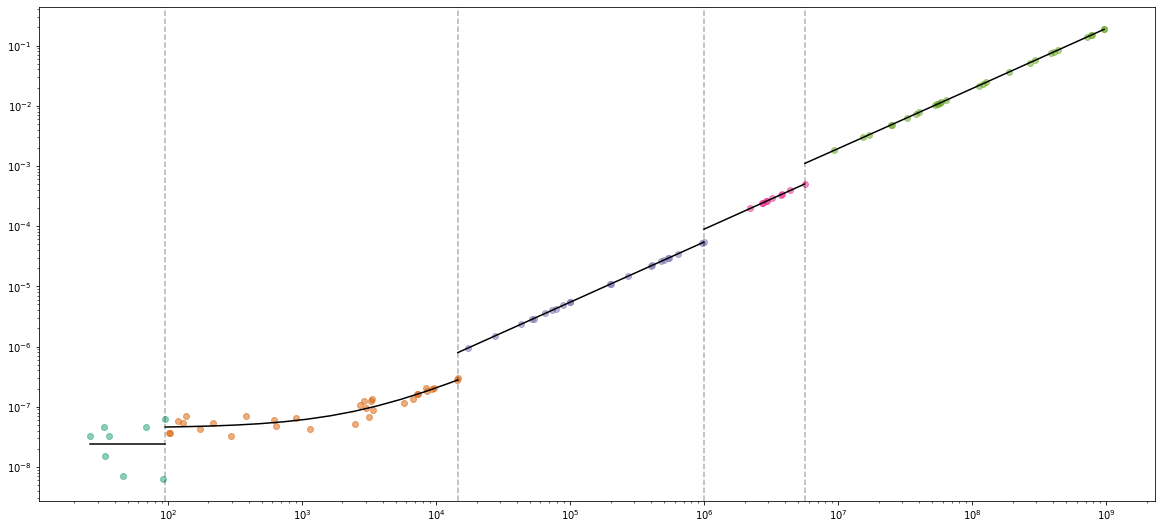

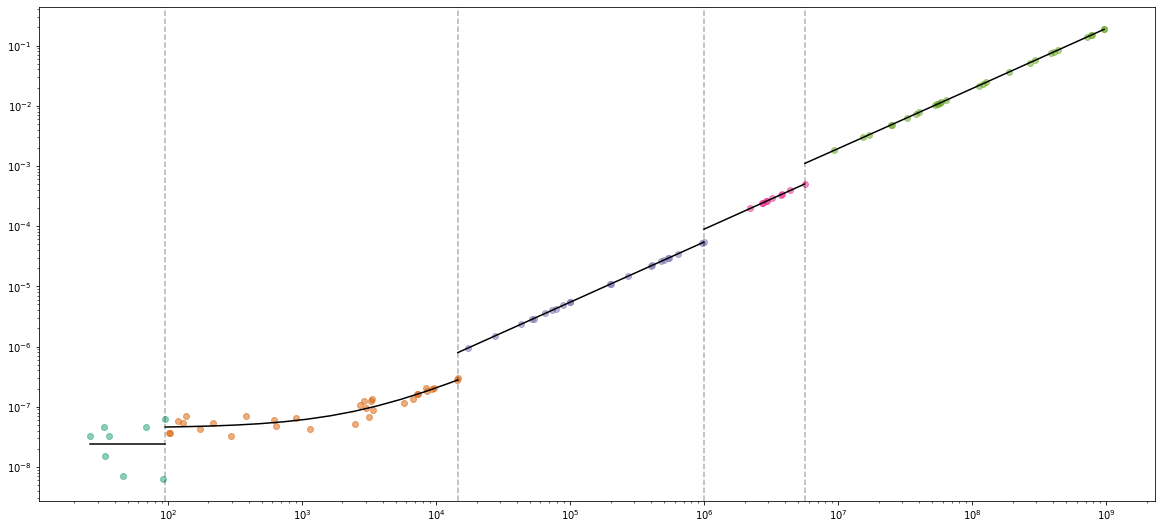

In [14]:
reg = do_regressions(noisy_df, 'log')
reg

## Generated data, generated heteroscedastic noise

Let's try to add some homoscedastic noise.

In [15]:
noisy_df = new_df.copy()
noisy_df['duration'] += numpy.random.normal(size=len(noisy_df), scale=2e-12)*noisy_df['size']

### Classical linear regression

Top-down   : 0.018 seconds
Breakpoints: []
Bottom-up  : 0.002 seconds
Breakpoints: []


-inf < x ≤ inf
	y ~ 1.940e-10x + -3.976e-05

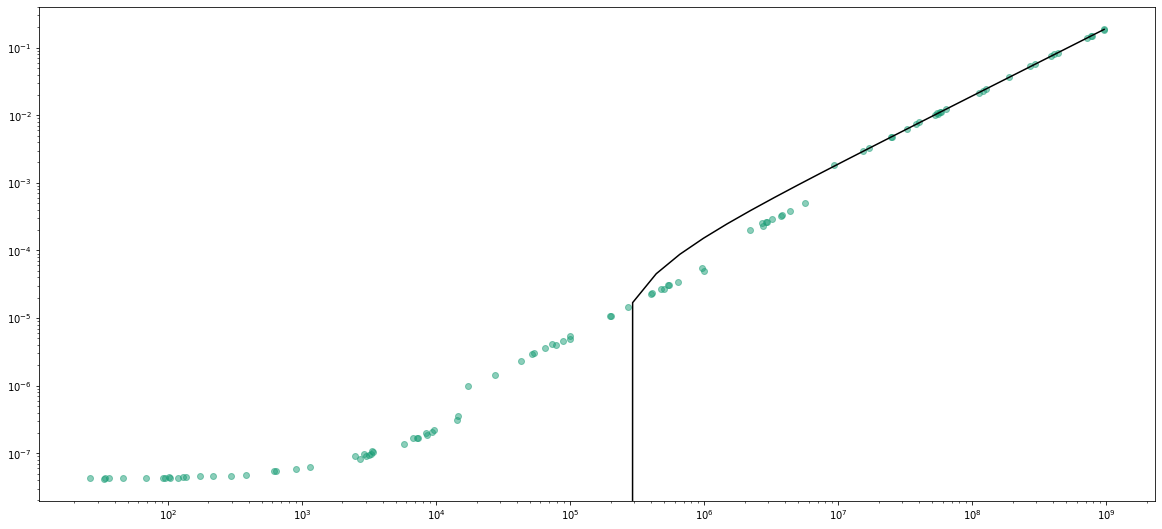

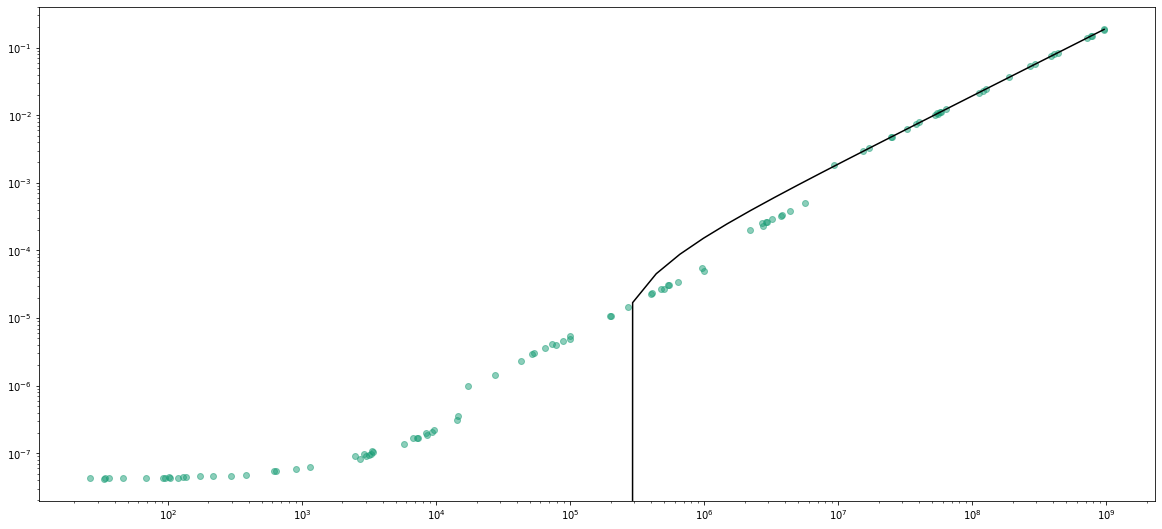

In [16]:
reg = do_regressions(noisy_df, 'BIC')
reg

### Weighted linear regression

Top-down   : 0.117 seconds
Breakpoints: [14495, 992466, 5629667]
Bottom-up  : 0.025 seconds
Breakpoints: [14495, 992466, 5629667]


-inf < x ≤ 1.450e+04
	y ~ 1.856e-11x + 4.173e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.492e-11x + -2.835e-08
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.674e-11x + 8.578e-06
5.630e+06 < x ≤ inf
	y ~ 1.941e-10x + -1.712e-05

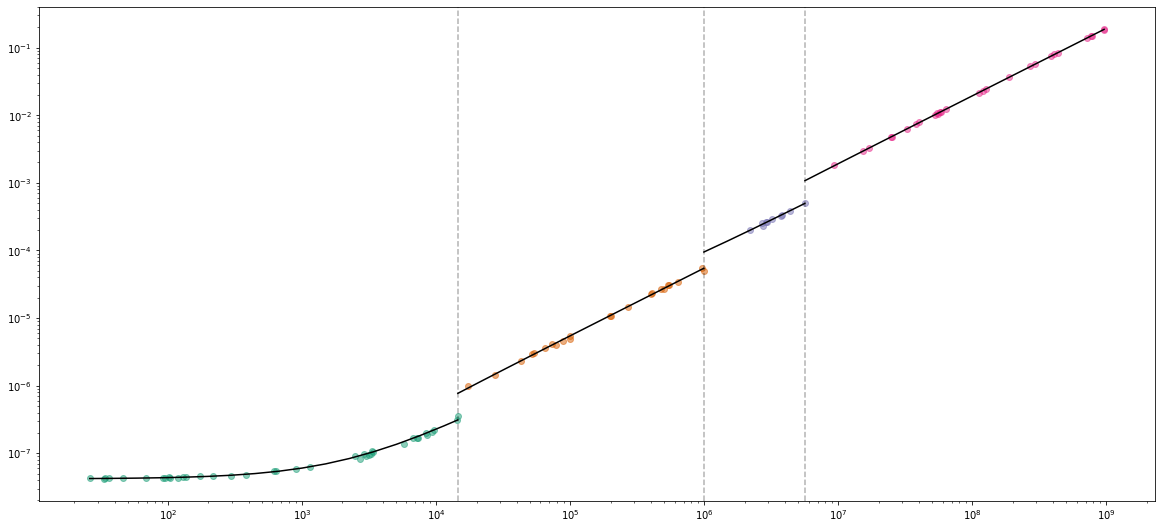

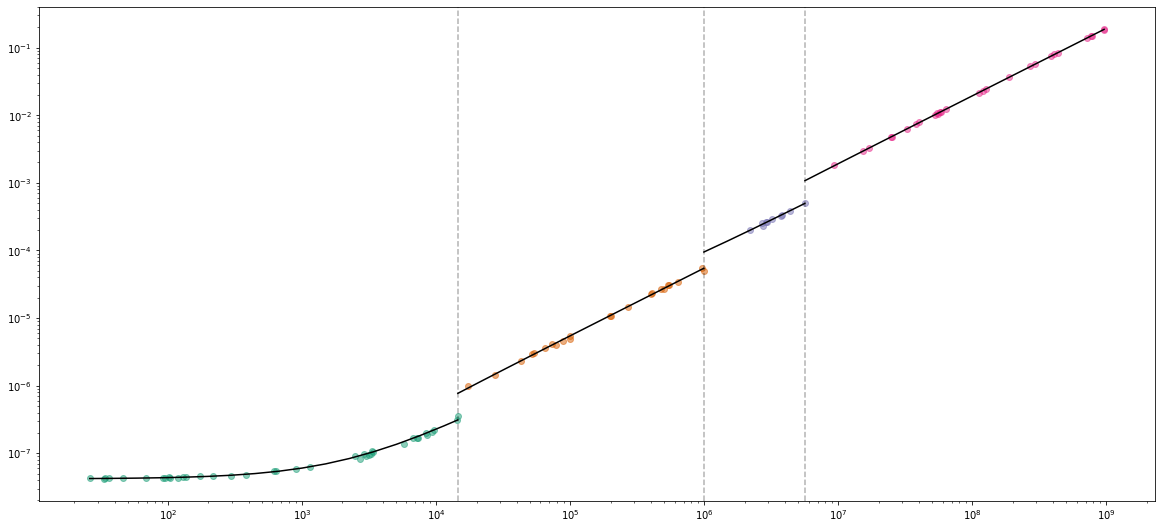

In [17]:
reg = do_regressions(noisy_df, 'weighted')
reg

### Log regression

Top-down   : 2.689 seconds
Breakpoints: [14495, 992466, 5629667]
Bottom-up  : 0.150 seconds
Breakpoints: [14495, 992466, 5629667]


-inf < x ≤ 1.450e+04
	y ~ 1.832e-11x + 4.160e-08
1.450e+04 < x ≤ 9.925e+05
	y ~ 5.416e-11x + 3.430e-08
9.925e+05 < x ≤ 5.630e+06
	y ~ 8.731e-11x + 6.660e-06
5.630e+06 < x ≤ inf
	y ~ 1.926e-10x + 6.152e-05

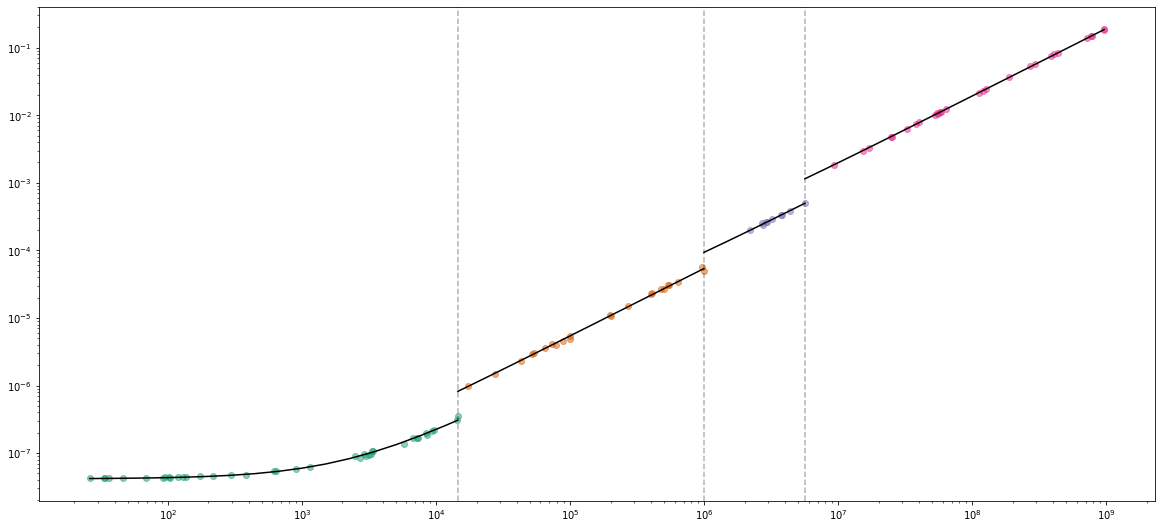

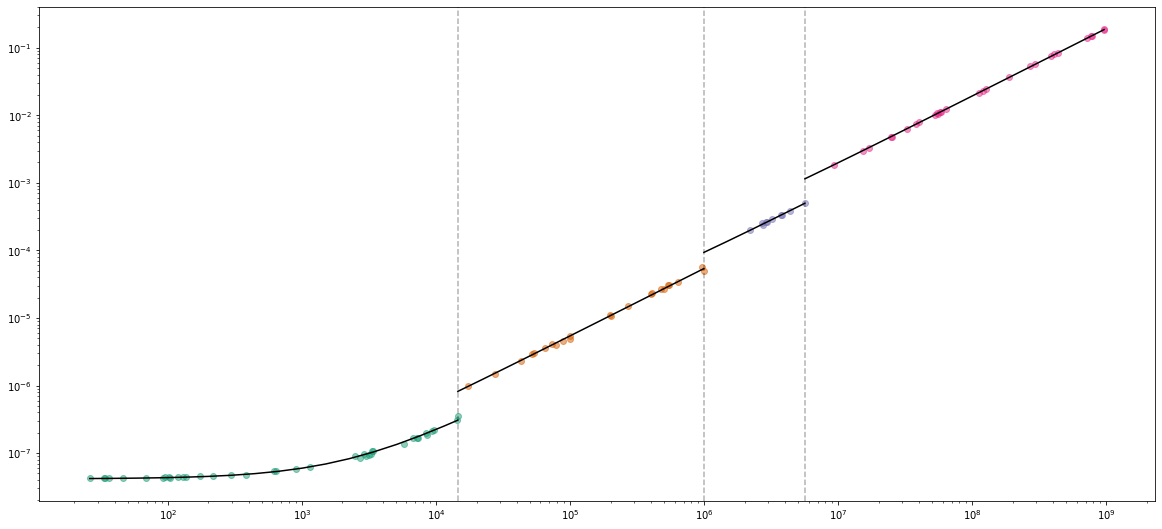

In [18]:
reg = do_regressions(noisy_df, 'log')
reg